In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
courses_directory = "data/courses/"


def read_all_courses(name: str):
    all_tables = []
    for file in os.listdir(courses_directory):
        course_name = os.fsdecode(file)
        course_path = courses_directory + course_name
        all_tables.append(pd.read_csv(course_path + "/" + name))
    return pd.concat(all_tables)

In [3]:
courses_directory = "data/courses/"

course = read_all_courses("course.csv")
course_element = read_all_courses("course_element.csv")
course_graph = read_all_courses("course_graph.csv")
course_module = read_all_courses("course_module.csv")
solution_log = read_all_courses("solution_log.csv")
user_course_progress = read_all_courses("user_course_progress.csv")
user_element_progress = read_all_courses("user_element_progress.csv")
user_module_progress = read_all_courses("user_module_progress.csv")

In [4]:
def filter_module_progress(
    module_progress: pd.DataFrame, element_progress: pd.DataFrame
):
    """Убирает прогрессы по модулям, в которых были transferred задачи или autograde; по которым не было совершено попыток"""
    df = module_progress[module_progress["achieve_reason"] != "autograde"]
    element_progress["is_transferred"] = (
        element_progress["achieve_reason"] == "transferred"
    ).astype(int)
    tries_sum = (
        element_progress[
            [
                "course_id",
                "user_id",
                "course_module_id",
                "course_element_id",
                "tries_count",
                "is_transferred",
            ]
        ]
        .groupby(["course_id", "course_module_id", "user_id"])
        .sum()
        .reset_index()
    )
    df = df.merge(
        tries_sum, on=["course_id", "course_module_id", "user_id"], how="left"
    )
    df = df[(df["is_transferred"] == 0) & (df["tries_count"] > 0)]
    return df

In [5]:
def another_filter_module_progress(
    module_progress: pd.DataFrame, element_progress: pd.DataFrame
):
    """Убирает прогрессы по модулям, в которых был autograde; по которым не было совершено попыток"""
    df = module_progress[module_progress["achieve_reason"] != "autograde"]
    element_progress["is_transferred"] = (
        element_progress["achieve_reason"] == "transferred"
    ).astype(int)
    tries_sum = (
        element_progress[
            [
                "course_id",
                "user_id",
                "course_module_id",
                "course_element_id",
                "tries_count",
                "is_transferred",
            ]
        ]
        .groupby(["course_id", "course_module_id", "user_id"])
        .sum()
        .reset_index()
    )
    df = df.merge(
        tries_sum, on=["course_id", "course_module_id", "user_id"], how="left"
    )
    # df = df[(df['is_transferred'] == 0) & (df['tries_count'] > 0)]
    df = df[df["tries_count"] > 0]
    return df

### achieved_percentage

Доля получивших зачет из приступивших к модулю.

In [6]:
df = another_filter_module_progress(user_module_progress, user_element_progress)

In [7]:
agg_df = (
    df[["course_module_id", "is_achieved", "user_id"]]
    .groupby(["course_module_id"])
    .agg({"user_id": "count", "is_achieved": "sum"})
    .reset_index()
)
agg_df.head()

,course_module_id,user_id,is_achieved
0,4792,236,148
1,4793,201,136
2,4794,1479,470
3,4795,395,273
4,4796,132,109


In [8]:
achieved_percentage = pd.DataFrame(
    {
        "module_id": agg_df["course_module_id"],
        "achieved_percentage": agg_df["is_achieved"] / agg_df["user_id"],
    }
)

<Axes: xlabel='achieved_percentage', ylabel='Count'>

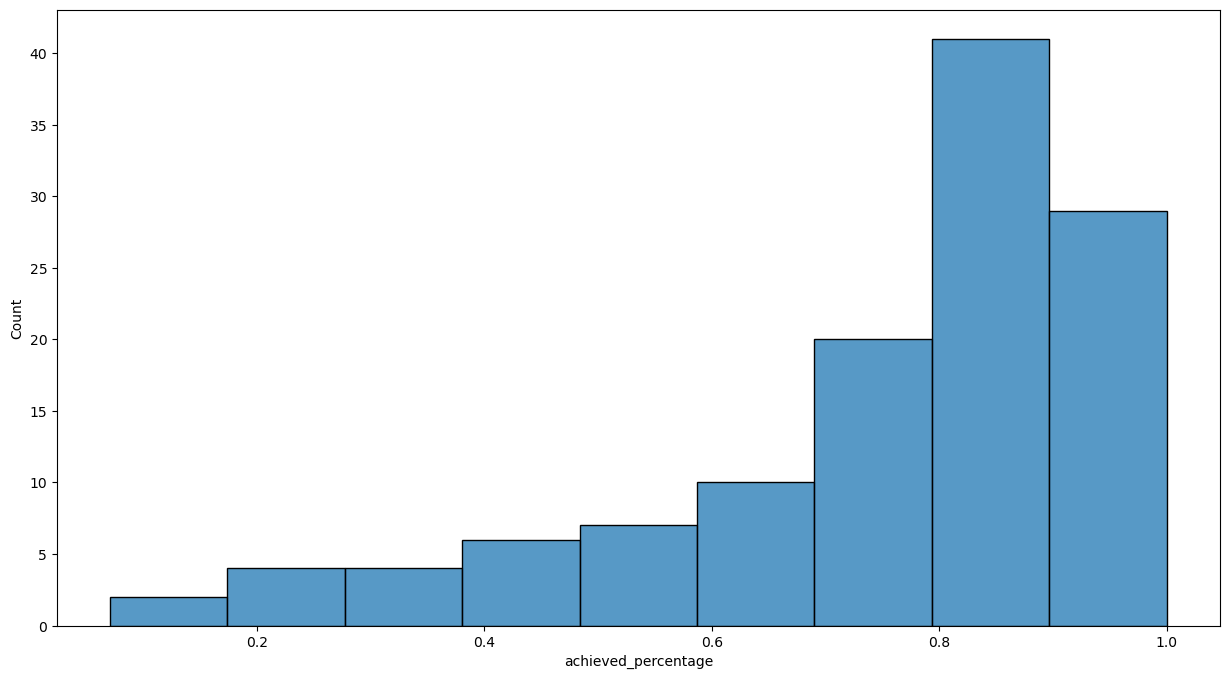

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(achieved_percentage["achieved_percentage"], ax=ax, binwidth=0.1)
# ax.set_xticks(np.arange(0, 11, 0.5));

In [10]:
no_task_count = len(course_module[course_module["tasks_max"] == 0])
print(f"Количество модулей без задач: {no_task_count}")

Количество модулей без задач: 11


In [11]:
achieved_percentage_threshold = 0.5

difficult_percentage = np.count_nonzero(
    achieved_percentage["achieved_percentage"] < achieved_percentage_threshold
) / len(achieved_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% модулей мы считаем сложными")

13.01 % модулей мы считаем сложными


### mean_score_percentage

Средняя доля набранных баллов

In [12]:
df = another_filter_module_progress(user_module_progress, user_element_progress)

In [13]:
course_module["course_module_id"] = course_module["id"]

In [14]:
df = df.merge(course_module, on=["course_id", "course_module_id"], how="left")
df = df[["user_id", "course_id", "course_module_id", "progress_current"]]

In [15]:
df

,user_id,course_id,course_module_id,progress_current
0,100120050110012994,560,4799,46.0
1,100120070111138088,560,4794,25.0
2,100120070511699993,560,4799,50.0
3,100120070111566303,560,4799,50.0
4,100119760112087287,560,4799,6.0
...,...,...,...,...
97231,100119700110739778,584,5012,9.0
97232,100119700110739778,584,5142,6.0
97233,100119700110739778,584,5013,9.0
97234,100119700110739778,584,5026,5.0


In [16]:
max_scores = (
    course_element[["module_id", "score"]]
    .groupby("module_id")
    .sum()
    .reset_index()
    .rename(columns={"module_id": "course_module_id", "score": "max_score"})
)
df = df.merge(max_scores, on="course_module_id")

In [17]:
df["score_percentage"] = df["progress_current"] / df["max_score"]

In [18]:
mean_score_percentage = (
    df[["course_module_id", "score_percentage"]]
    .groupby("course_module_id")
    .mean()
    .reset_index()
    .rename(
        columns={
            "course_module_id": "module_id",
            "score_percentage": "mean_score_percentage",
        }
    )
)

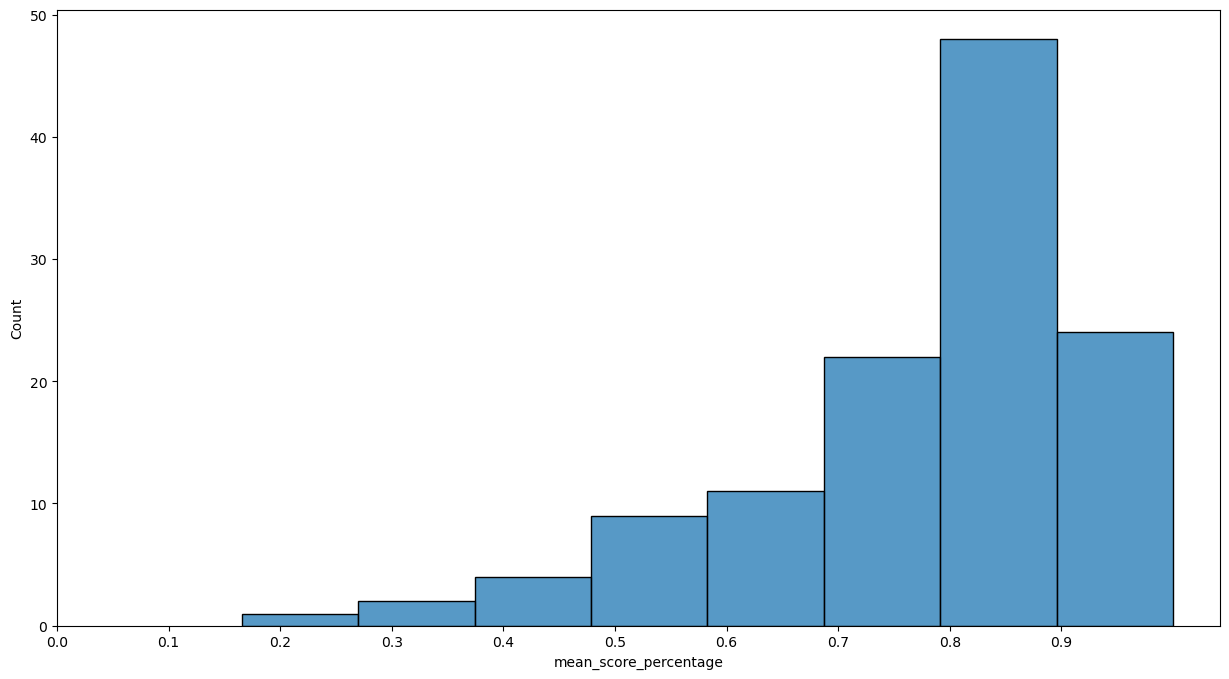

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(mean_score_percentage["mean_score_percentage"], binwidth=0.1, ax=ax)
ax.set_xticks(np.arange(0, 1, 0.1));

In [20]:
mean_score_percentage_threshold = 0.6

difficult_percentage = np.count_nonzero(
    mean_score_percentage["mean_score_percentage"] < mean_score_percentage_threshold
) / len(mean_score_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% модулей мы считаем сложными")

13.82 % модулей мы считаем сложными


### dev_mean_score_percentage

Среднее отличие доли набранных баллов у пользователя в данном модуле от модулей-пререквизитов.

In [21]:
df = another_filter_module_progress(user_module_progress, user_element_progress)
df

,id,user_id,course_id,course_module_id,progress_current,progress_failed,steps_done,is_achieved,is_closed,course_progress_id,...,time_closed,time_achieved,time_unlocked,tasks_done,time_done,is_done,achieve_reason,course_element_id,tries_count,is_transferred
1,5479980,100120050110012994,560,4799,46.0,0.0,31,True,False,378242,...,NaN,2021-11-15 20:37:51.555016,2021-11-04 02:08:17.030108,22,NaN,False,solved,217683,44,0
2,6526762,100120070111138088,560,4794,25.0,0.0,17,False,False,451310,...,NaN,NaN,2021-10-08 18:46:00.507560,7,NaN,False,NaN,196199,66,0
3,5497678,100120070511699993,560,4799,50.0,0.0,32,True,True,379784,...,2021-11-15 20:50:22.739024,2021-11-06 19:43:24.693248,2021-09-07 22:05:13.750158,23,2021-11-15 20:50:22.739024,True,solved,217683,85,0
5,5530018,100120070111566303,560,4799,50.0,0.0,32,True,True,383012,...,2021-11-15 20:53:17.347814,2021-11-15 20:39:22.741464,2021-09-02 11:38:25.698498,23,2021-11-15 20:53:17.347814,True,solved,217683,91,8
9,6342347,100119760112087287,560,4799,6.0,0.0,5,False,False,439651,...,NaN,NaN,2021-10-01 22:12:32.831471,2,NaN,False,NaN,217683,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148412,5647437,100119700110739778,584,5012,9.0,0.0,18,True,False,392150,...,NaN,2021-09-06 19:06:50.131253,2021-09-06 19:06:50.131253,9,2021-09-06 19:06:50.131253,True,solved,29375,18,18
148413,5647456,100119700110739778,584,5142,6.0,0.0,6,False,False,392150,...,NaN,NaN,NaN,6,NaN,False,NaN,212621,6,6
148414,5647454,100119700110739778,584,5013,9.0,0.0,21,True,False,392150,...,NaN,2021-09-06 19:06:50.131253,2021-09-06 19:06:43.522345,9,2021-09-06 19:06:50.131253,True,solved,35507,21,21
148415,5647462,100119700110739778,584,5026,5.0,0.0,15,False,False,392150,...,NaN,NaN,2021-09-06 19:06:50.131253,5,NaN,False,NaN,228490,15,15


In [22]:
course_module["course_module_id"] = course_module["id"]
df = df.merge(course_module, on=["course_id", "course_module_id"], how="left")
df = df[["user_id", "course_id", "course_module_id", "progress_current"]]
max_scores = (
    course_element[["module_id", "score"]]
    .groupby("module_id")
    .sum()
    .reset_index()
    .rename(columns={"module_id": "course_module_id", "score": "max_score"})
)
df = df.merge(max_scores, on="course_module_id")
df["score_percentage"] = df["progress_current"] / df["max_score"]

In [23]:
df

,user_id,course_id,course_module_id,progress_current,max_score,score_percentage
0,100120050110012994,560,4799,46.0,50.0,0.92
1,100120070511699993,560,4799,50.0,50.0,1.00
2,100120070111566303,560,4799,50.0,50.0,1.00
3,100119760112087287,560,4799,6.0,50.0,0.12
4,100120040110756670,560,4799,37.0,50.0,0.74
...,...,...,...,...,...,...
97231,100120040111027322,584,5019,10.0,10.0,1.00
97232,100119920110471037,584,5019,2.0,10.0,0.20
97233,100120060111692729,584,5019,9.0,10.0,0.90
97234,100120060111220946,584,5019,2.0,10.0,0.20


In [24]:
prerequisites = {}
for to_module, in_arrows in course_graph.groupby("to_module_id"):
    prerequisites[to_module] = list(in_arrows["from_module_id"])

In [25]:
from tqdm import tqdm

mean_prereq_score_percentages = []
for index, row in tqdm(df.iterrows()):
    user_scores = df[df["user_id"] == row["user_id"]]
    module_id = int(row["course_module_id"])
    if module_id in prerequisites.keys():
        user_scores = user_scores[
            user_scores["course_module_id"].isin(prerequisites[module_id])
        ]
        mean_prereq_score_percentage = user_scores["score_percentage"].mean()
    else:
        mean_prereq_score_percentage = np.nan
    mean_prereq_score_percentages.append(mean_prereq_score_percentage)

97236it [00:34, 2832.22it/s]


In [26]:
df["mean_prereq_score_percentage"] = mean_prereq_score_percentages
df["dev"] = df["mean_prereq_score_percentage"] - df["score_percentage"]

In [27]:
dev_mean_score_percentage = (
    df[["course_module_id", "dev"]]
    .groupby("course_module_id")
    .mean()
    .reset_index()
    .rename(
        columns={"course_module_id": "module_id", "dev": "dev_mean_score_percentage"}
    )
)

<Axes: xlabel='dev_mean_score_percentage', ylabel='Count'>

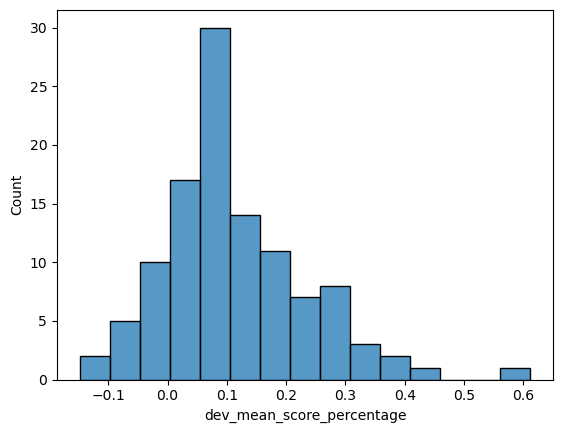

In [28]:
sns.histplot(dev_mean_score_percentage["dev_mean_score_percentage"], binwidth=0.05)

In [29]:
dev_mean_score_percentage_threshold = 0.3

difficult_percentage = np.count_nonzero(
    dev_mean_score_percentage["dev_mean_score_percentage"]
    > dev_mean_score_percentage_threshold
) / len(dev_mean_score_percentage)
print("{:.2f}".format(difficult_percentage * 100), "% модулей мы считаем сложными")

6.50 % модулей мы считаем сложными


## Линейные связи

In [30]:
from functools import reduce

df_merged = reduce(
    lambda left, right: pd.merge(left, right, on=["module_id"], how="outer"),
    [mean_score_percentage, dev_mean_score_percentage, achieved_percentage],
)
df_merged

,module_id,mean_score_percentage,dev_mean_score_percentage,achieved_percentage
0,4792,0.703828,0.169685,0.627119
1,4793,0.690011,0.209882,0.676617
2,4794,0.408409,NaN,0.317782
3,4795,0.722218,0.155541,0.691139
4,4796,0.789009,0.067967,0.825758
...,...,...,...,...
118,5545,0.797169,NaN,0.731942
119,5546,0.680272,0.242432,0.653061
120,5547,0.606838,0.328976,0.538462
121,5548,0.749766,0.183911,0.783505


<Axes: >

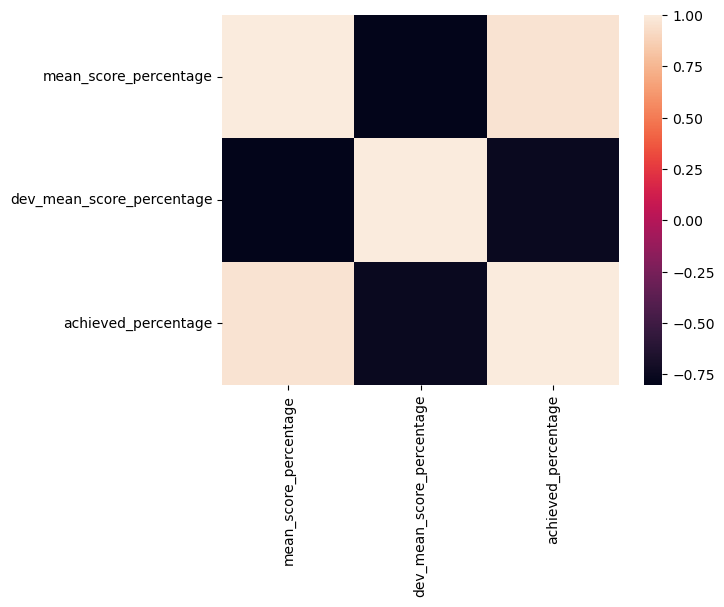

In [31]:
df_merged = df_merged.set_index("module_id")
sns.heatmap(df_merged.corr())

In [32]:
df_merged.corr()

,mean_score_percentage,dev_mean_score_percentage,achieved_percentage
mean_score_percentage,1.000000,-0.800697,0.964317
dev_mean_score_percentage,-0.800697,1.000000,-0.756809
achieved_percentage,0.964317,-0.756809,1.000000


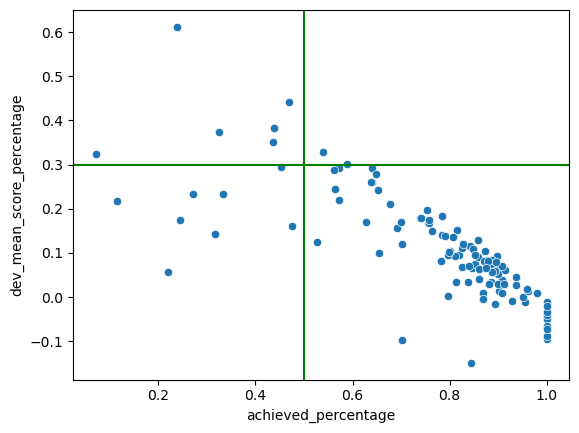

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(
    df_merged, x="achieved_percentage", y="dev_mean_score_percentage", ax=ax
)
plt.axhline(y=dev_mean_score_percentage_threshold, color="g")
plt.axvline(x=achieved_percentage_threshold, color="g")
plt.xlabel("achieved_percentage")
plt.ylabel("dev_mean_score_percentage");